# **Table Detection and Extraction From Image Project**

# **Step 1 : Detecting the table**

**Installing required dependencies**


In [65]:
# Installing tesseract in system
# !sudo apt install tesseract-ocr-fra
# !pip install pytesseract transformers ultralyticsplus==0.0.23 ultralytics==8.0.21

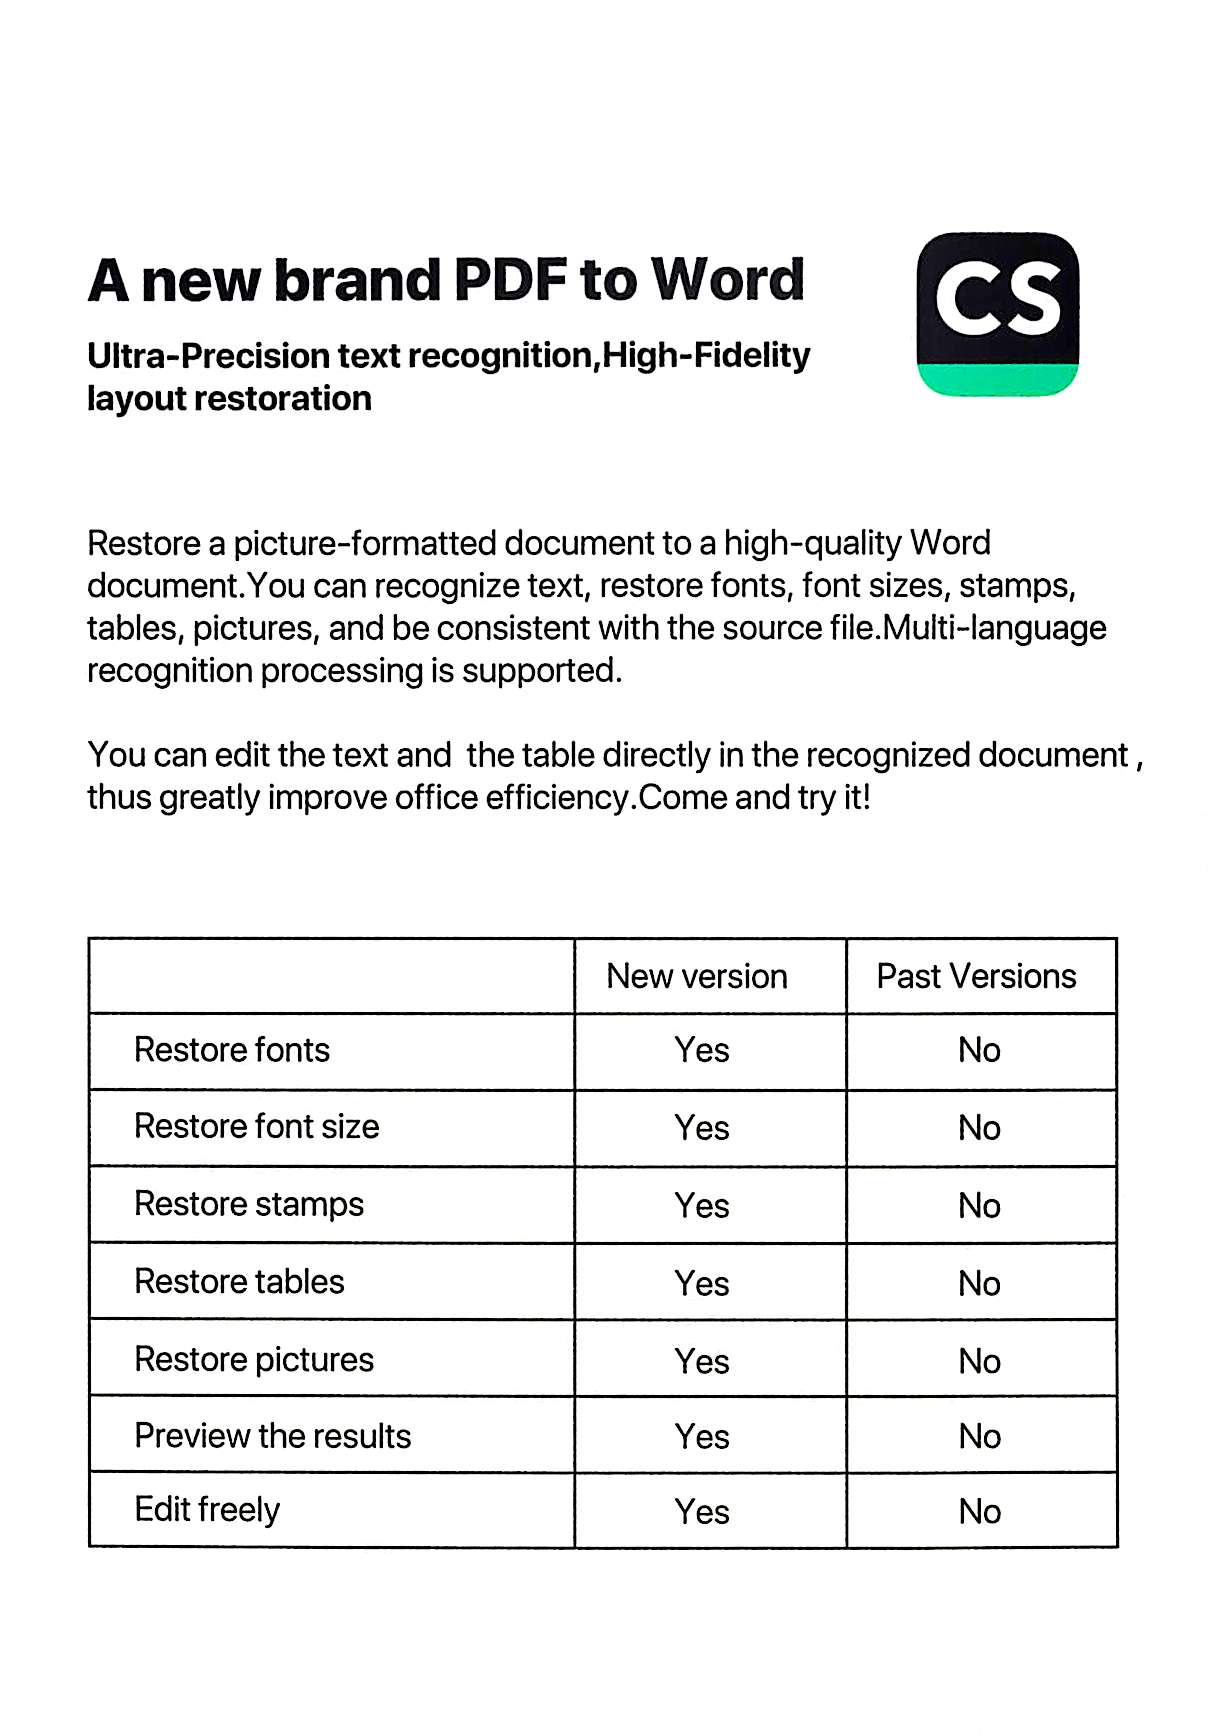

In [66]:
import numpy as np
import pandas as pd


import pytesseract
from pytesseract import Output
from ultralyticsplus import YOLO, render_result
from PIL import Image #pillow

image = 'test3.jpg'
img = Image.open(image)
img

Ultralytics YOLOv8.0.21 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs
0: 640x448 1 bordered, 1139.5ms
Speed: 0.9ms pre-process, 1139.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Boxes:  tensor([[8.20000e+01, 9.28000e+02, 1.12500e+03, 1.54900e+03, 9.55885e-01, 0.00000e+00]])


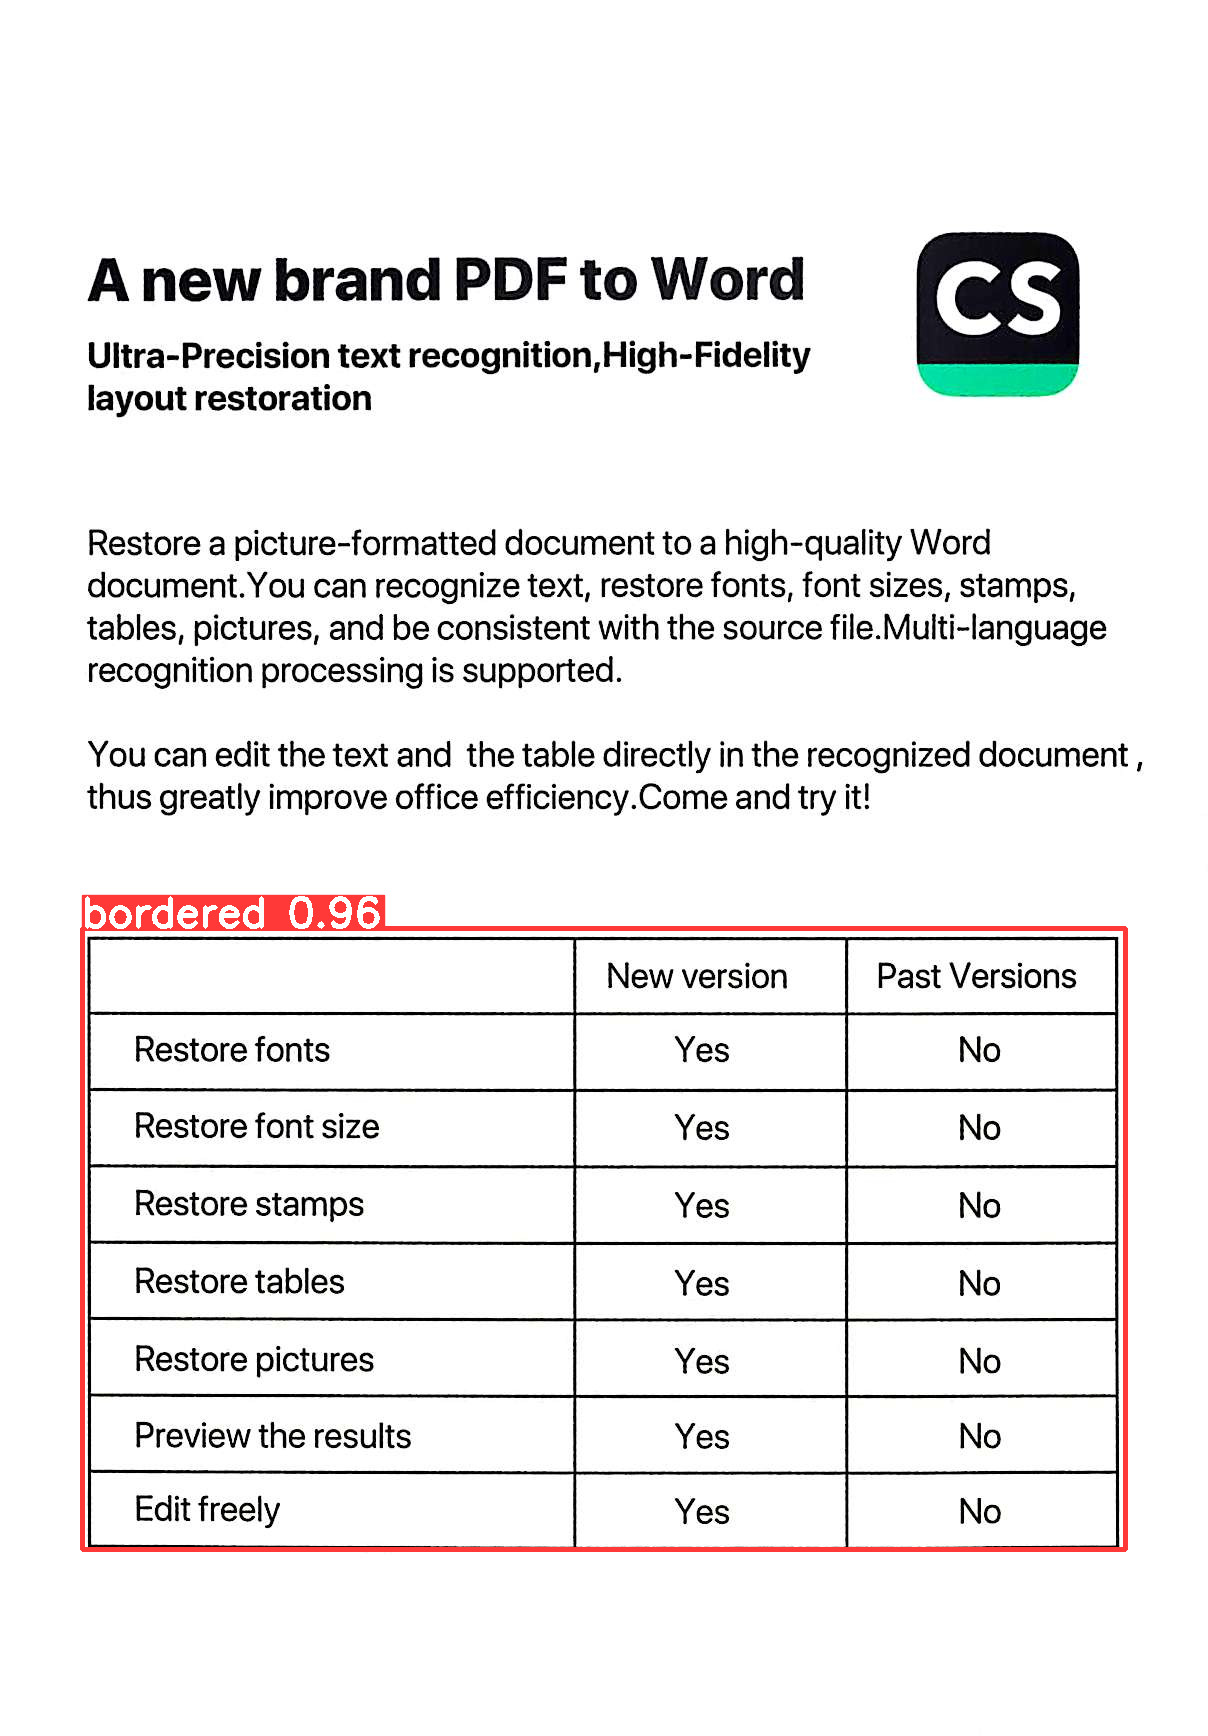

In [67]:
# load model
model = YOLO('keremberke/yolov8m-table-extraction')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

# perform inference
results = model.predict(img)

# observe results
print('Boxes: ', results[0].boxes)
render = render_result(model=model, image=img, result=results[0])
# render.save("table_detected.png")
render

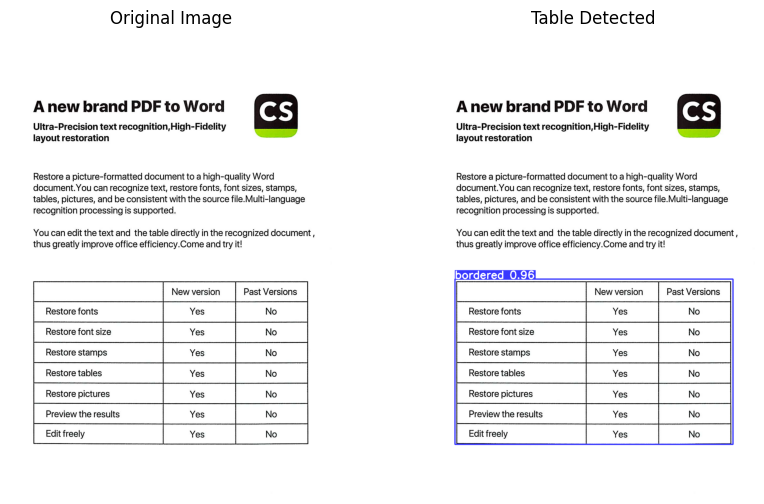

In [111]:
import matplotlib.pyplot as plt
"""
  The code below is for visualization purposes only.
"""
img_org = cv2.imread("test3.jpg")
img_dete = cv2.imread("table_detected.png")

fig = plt.figure(figsize=(10,6))
(ax1,ax2) = fig.subplots(1,2)
ax1.imshow(img_org)
ax2.imshow(img_dete)
ax1.set_title("Original Image")
ax2.set_title("Table Detected")
ax1.axis("off")
ax2.axis("off")
fig.savefig("combined_org_dete_img.png")

In [68]:
img = np.array(Image.open(image))
tables_vesul=[]
tables=[]

for i in range(len(results[0].boxes.data.numpy())):
  x1, y1, x2, y2, _, _ = tuple(int(item) for item in results[0].boxes.data.numpy()[i]) # (96, 586, 947, 1286)
  x2+=10
  y2+=10
  x1-=10
  y1-=10

  #cropping
  cropped_image = img[y1:y2, x1:x2]
  print(cropped_image.shape)
  tables.append(cropped_image)
  image_tab = Image.fromarray(cropped_image)
  # image_tab.save("extracted_img.png")
  tables_vesul.append(image_tab)


(641, 1063, 3)


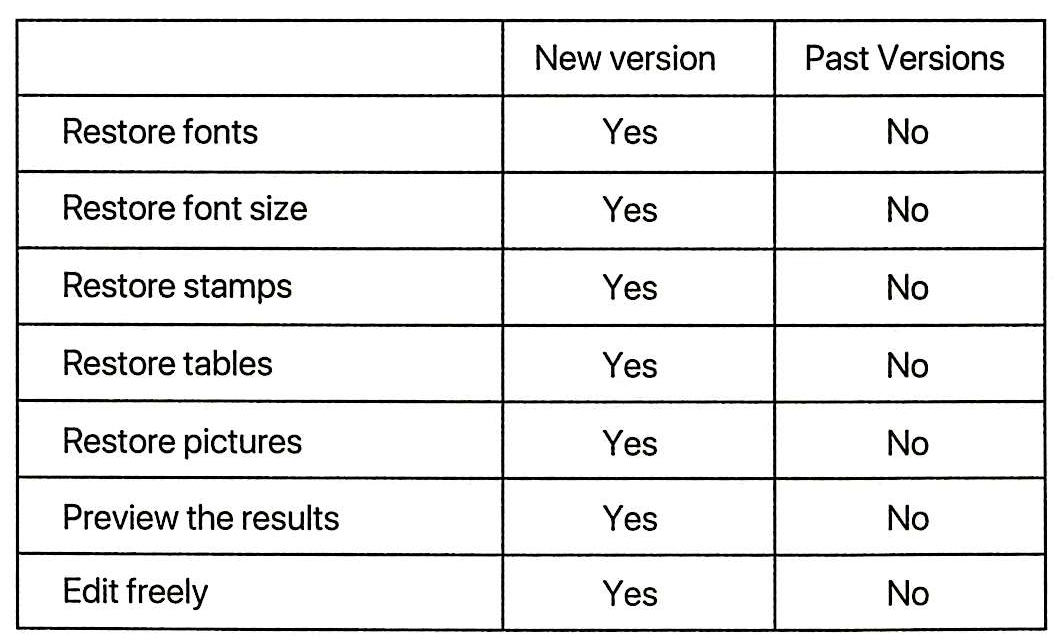

In [69]:
tables_vesul[0]

# **Step 2 : Table recognition**

# Image Preprpcessing



In [70]:
import cv2
import subprocess

def add_10_percent_padding(img):
    image_height = img.shape[0]
    padding = int(image_height * 0.1)
    padded_img = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    return padded_img

def img_Preprocessing(img):
  # Grey-scaling
  grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # converting it to binary image by Thresholding
  thresholded_image = cv2.threshold(grayscale_image, 127, 255, cv2.THRESH_BINARY)[1]
  # Inverting
  inverted_image = cv2.bitwise_not(thresholded_image)
  return inverted_image

def img_Preprocessing_ocr(img):
  # Thresholding
  thresholded_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
  # Inverting
  # inverted_image = cv2.bitwise_not(thresholded_image)
  return thresholded_image

# Combining Vertical And Horizontal Lines
def combine_eroded_images(img):
  # Eroding Vertical Lines
  hor = np.array([[1,1,1,1,1,1]])
  ver_erode_img = cv2.erode(img, hor, iterations=5)
  ver_dilate_img = cv2.dilate(ver_erode_img, hor, iterations=10)
  # Eroding Horizontal Lines
  ver = np.array([[1],[1],[1],[1],[1],[1],[1]])
  hor_erode_img = cv2.erode(img, ver, iterations=5)
  hor_dilate_img = cv2.dilate(hor_erode_img, ver, iterations=10)
  # Combining
  combined_image = cv2.add(ver_dilate_img, hor_dilate_img)
  # dilate combined_image to make lines thicker
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
  combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=5)
  return combined_image_dilated

# Removing The Lines
def subtract_combined_and_dilated_image_from_original_image(processed_img,combined_image_dilated):
    img_without_lines = cv2.subtract(processed_img,combined_image_dilated)
    # remove noise with erode and dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    image_without_lines_noise_removed = cv2.erode(img_without_lines, kernel)
    image_without_lines_noise_removed = cv2.dilate(image_without_lines_noise_removed, kernel)
    return image_without_lines_noise_removed


In [71]:
"""
  The code below is for visualization purposes only.
"""
# Eroding Vertical Lines
def erode_vertical_lines(img):
  hor = np.array([[1,1,1,1,1,1]])
  ver_erode_img = cv2.erode(img, hor, iterations=10)
  ver_dilate_img = cv2.dilate(ver_erode_img, hor, iterations=10)
  return ver_dilate_img

# Eroding Horizontal Lines
def erode_horizontal_lines(img):
    ver = np.array([[1],[1],[1],[1],[1],[1],[1]])
    hor_erode_img = cv2.erode(img, ver, iterations=10)
    hor_dilate_img = cv2.dilate(hor_erode_img, ver, iterations=5)
    return hor_dilate_img

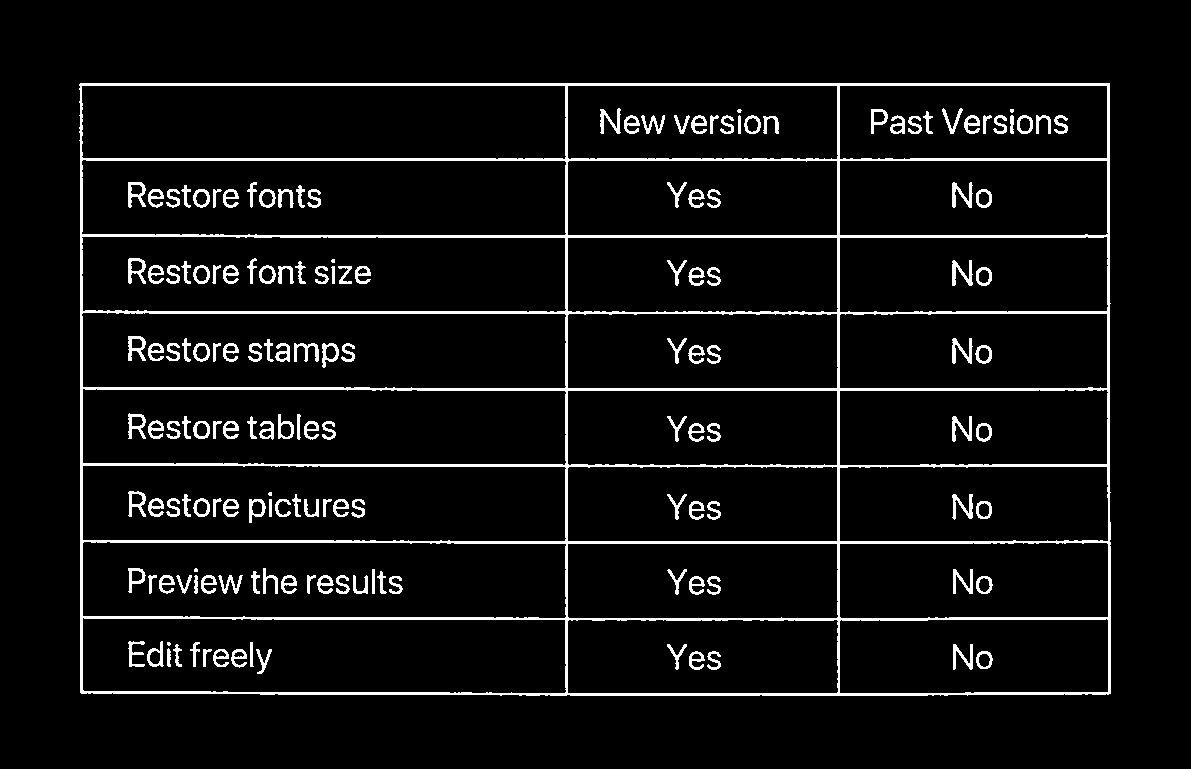

In [72]:
image_with_padding = add_10_percent_padding(tables[0])
processed_img = img_Preprocessing(image_with_padding)
Image.fromarray(processed_img)
# peoces.save("processed_img.png")

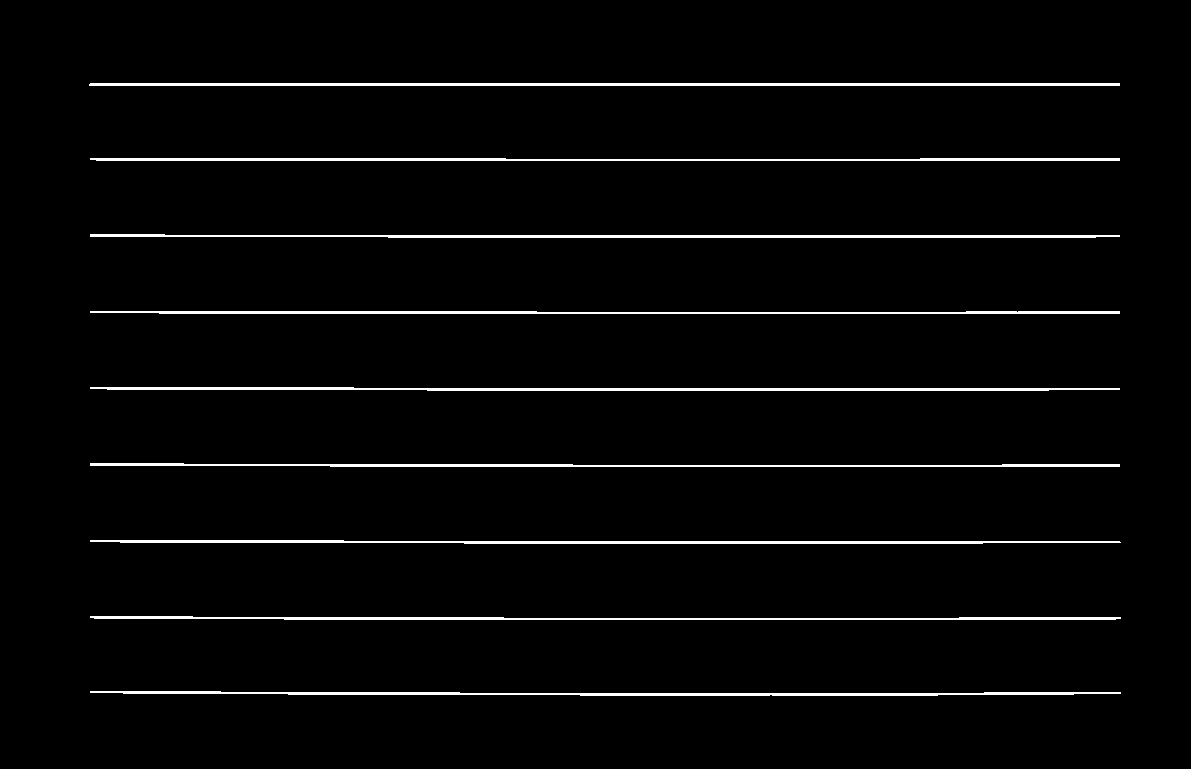

In [73]:
ver_dilate_img = erode_vertical_lines(processed_img)
Image.fromarray(ver_dilate_img)
# img.save("ver_dilate_img.png")

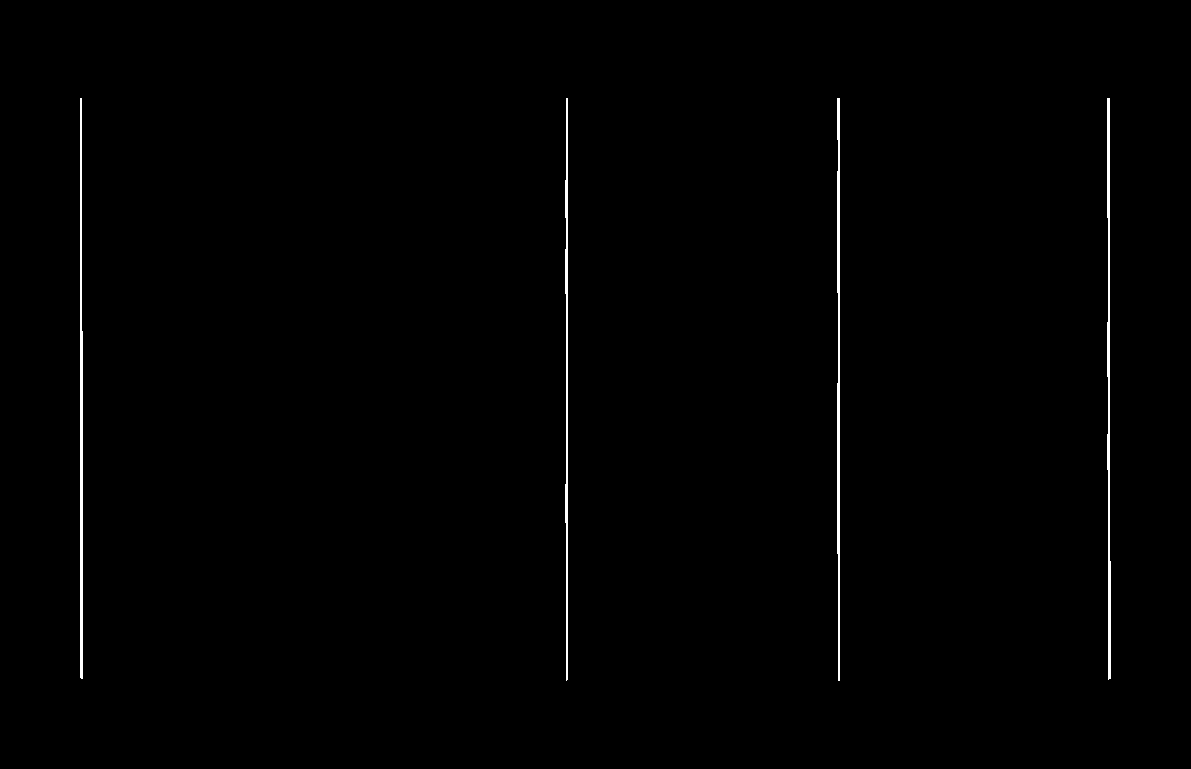

In [74]:
hor_dilate_img = erode_horizontal_lines(processed_img)
Image.fromarray(hor_dilate_img)
# img.save("hor_dilate_img.png")

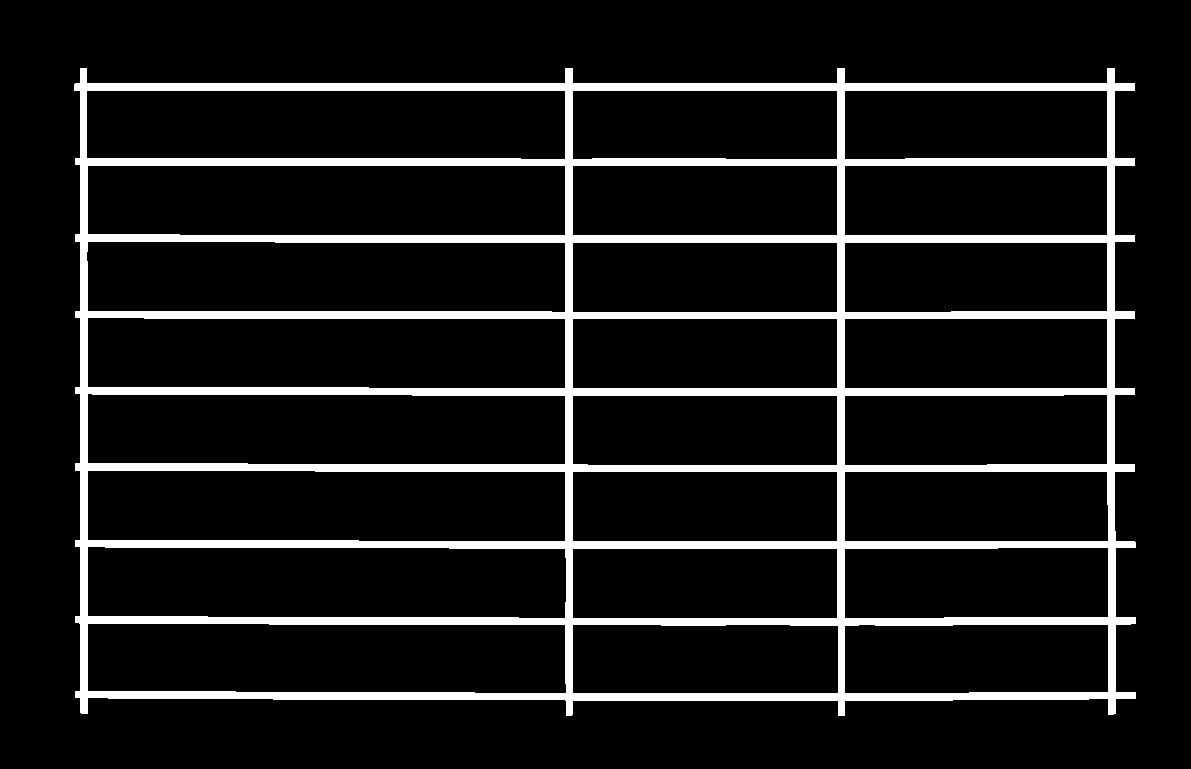

In [75]:
combined_img = combine_eroded_images(processed_img)
Image.fromarray(combined_img)
# img.save("combined_img.png")

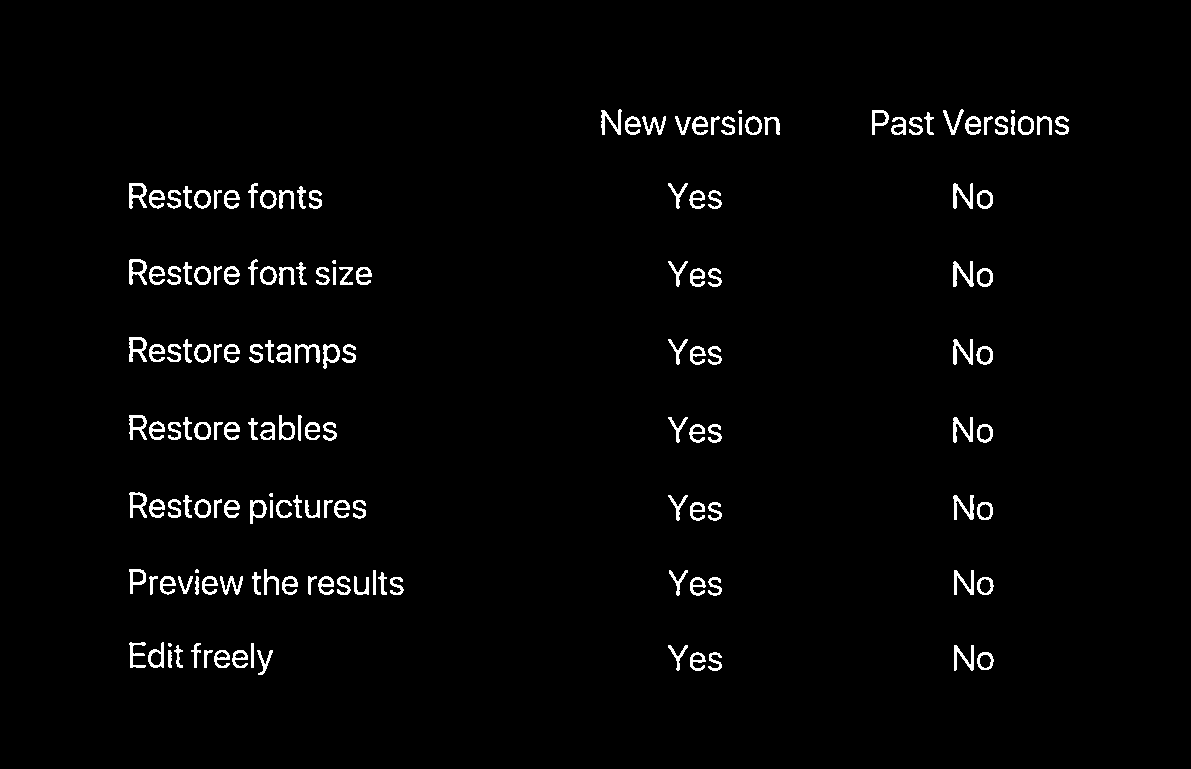

In [76]:
img_without_lines = subtract_combined_and_dilated_image_from_original_image(processed_img,combined_img)
Image.fromarray(img_without_lines)
# img.save("img_without_lines.png")

# Finding the cells & extracting the text using OCR

In [77]:
import csv

# Use Dilation To Convert The Words Into Blobs
def dilate_image(thresholded_image):
  kernel_to_remove_gaps_between_words = np.array([[1,1,1,1,1,1,1,1,1,1],[1,1,1,1,1,1,1,1,1,1]])
  dilated_image = cv2.dilate(thresholded_image, kernel_to_remove_gaps_between_words, iterations=5)
  simple_kernel = np.ones((5,5), np.uint8)
  dilated_image = cv2.dilate(dilated_image, simple_kernel, iterations=2)
  return dilated_image

# Find The Contours Of The Blobs
def find_contours(dilated_image,original_image):
    result = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = result[0]
    # The code below is for visualization purposes only.
    image_with_contours_drawn = original_image.copy()
    cv2.drawContours(image_with_contours_drawn,contours, -1, (0, 255, 0), 3)
    return contours,image_with_contours_drawn

# Convert The Blobs Into Bounding Boxes
def convert_contours_to_bounding_boxes(contours,original_image):
    bounding_boxes = []
    image_bounding_boxes = original_image.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, h))
        # The code below is for visualization purposes only.
        image_bounding_boxes = cv2.rectangle(image_bounding_boxes, (x, y), (x + w, y + h), (0, 255, 0), 5)
    return bounding_boxes,image_bounding_boxes

# Sorting The Bounding Boxes By X And Y Coordinates To Make Rows And Columns

def get_mean_height_of_bounding_boxes(bounding_boxes):
    heights = []
    for bounding_box in bounding_boxes:
        x, y, w, h = bounding_box
        heights.append(h)
    return np.mean(heights)

def sort_and_club_all_bounding_boxes_by_similar_y_coordinates_into_rows(bounding_boxes,mean_height):
    # sort_bounding_boxes_by_y_coordinate
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])
    # club_all_bounding_boxes_by_similar_y_coordinates_into_rows
    rows = []
    half_of_mean_height = mean_height / 2
    current_row = [bounding_boxes[0]]
    for bounding_box in bounding_boxes[1:]:
        current_bounding_box_y = bounding_box[1]
        previous_bounding_box_y = current_row[-1][1]
        distance_between_bounding_boxes = abs(current_bounding_box_y - previous_bounding_box_y)
        if distance_between_bounding_boxes <= half_of_mean_height:
            current_row.append(bounding_box)
        else:
            rows.append(current_row)
            current_row = [ bounding_box ]
    rows.append(current_row)

    # sort_all_rows_by_x_coordinate
    for row in rows:
        row.sort(key=lambda x: x[0])


    # Sort rows by the Y coordinate of the first box in each row
    # rows.sort(key=lambda row: row[0][1])

    return rows

# Extracting The Text From The Bounding Boxes Using OCR

def crop_each_bounding_box_and_ocr(rows,original_image):
    table = []
    current_row = []
    image_number = 0
    for row in rows:
        for bounding_box in row:
            x, y, w, h = bounding_box
            # y-=4
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
            image_without_lines_noise_removed = cv2.erode(add_10_percent_padding(original_image[y:y+h, x:x+w]), kernel)
            cropped_image = cv2.dilate(image_without_lines_noise_removed, kernel)
            image_slice_path = "img_" + str(image_number) + ".jpg"
            cv2.imwrite(image_slice_path, cropped_image)
            results_from_ocr = tesseract_results(image_slice_path)
            current_row.append(results_from_ocr)
            image_number += 1
        table.append(current_row)
        current_row = []
    return table

def tesseract_results(image_path):
    # Construct the Tesseract OCR command
    tesseract_command = (
        'tesseract ' + image_path + ' - -l fra+eng --oem 3 --psm 6 --dpi 300 '
    )
    # tesseract_command = ' tesseract  - -l fra+eng  --oem 3 --psm 6 --dpi 300 '

    # Run the Tesseract command using subprocess
    output = subprocess.getoutput(tesseract_command)
    # output = pytesseract.image_to_string(image_path)

    # Strip any leading or trailing whitespace from the output
    output = output.strip('|')
    output = output.replace('\n', ' ')
    output = output.strip()
    return output

# Generating The CSV
"""
def generate_csv_file(talbes):
    with open("output.csv", "w") as f:
        for row in talbes:
            f.write(",".join(row) + "\n")
"""
def generate_csv_file(input_table):
    with open("final_result.csv", 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in input_table:
            csv_writer.writerow(row)

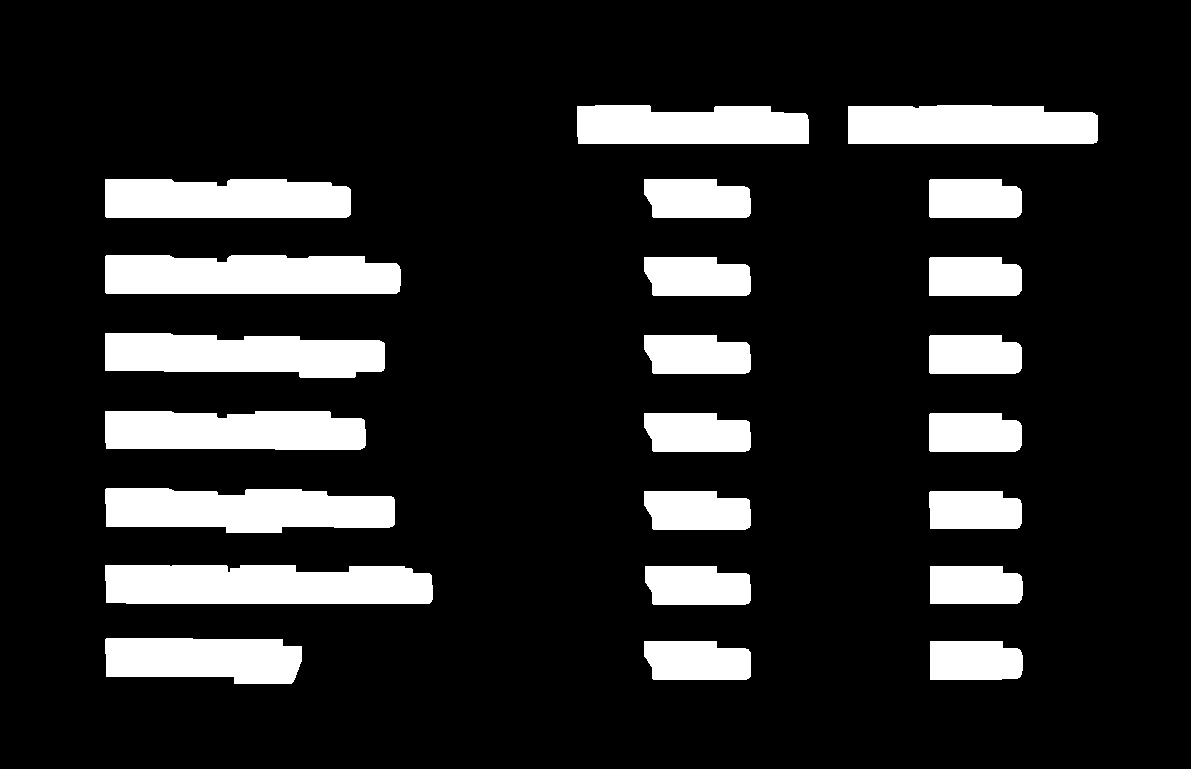

In [78]:
dilated_img = dilate_image(img_without_lines)
Image.fromarray(dilated_img)
# img.save("dilated_img.png")

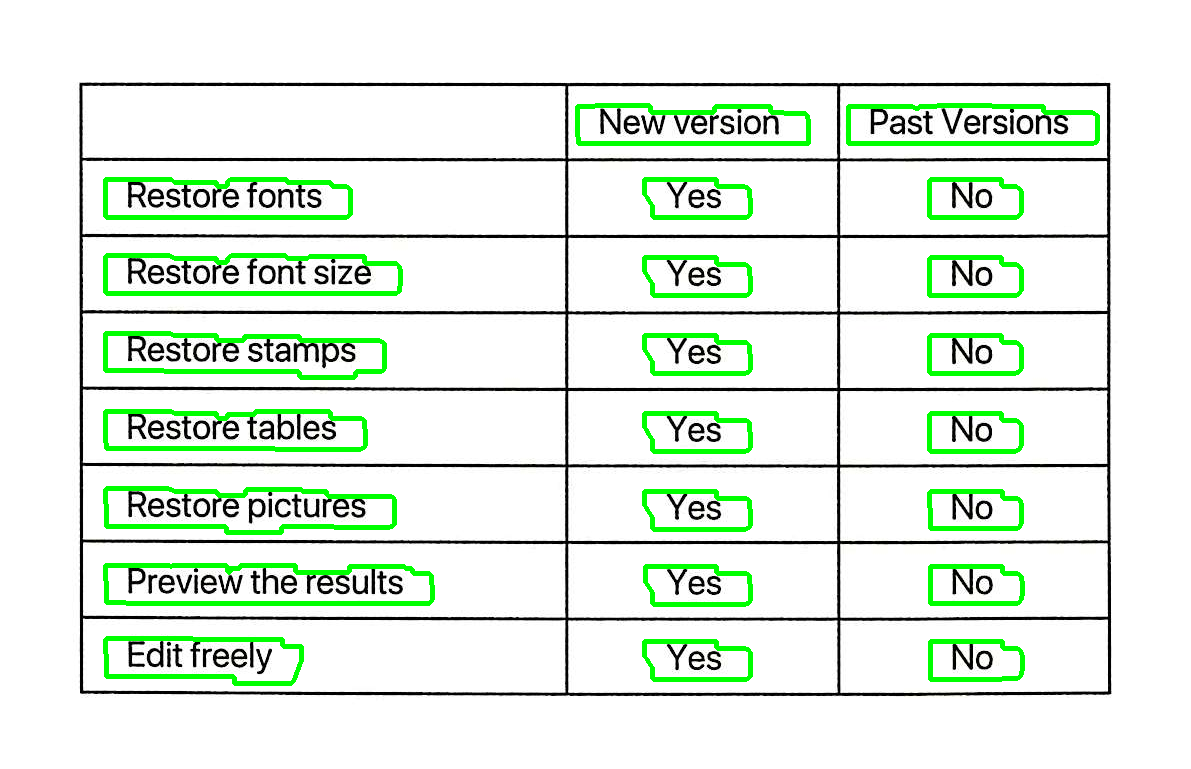

In [79]:
contours,image_with_contours_drawn = find_contours(dilated_img,image_with_padding)
Image.fromarray(image_with_contours_drawn)
# img.save("image_with_contours_drawn.png")

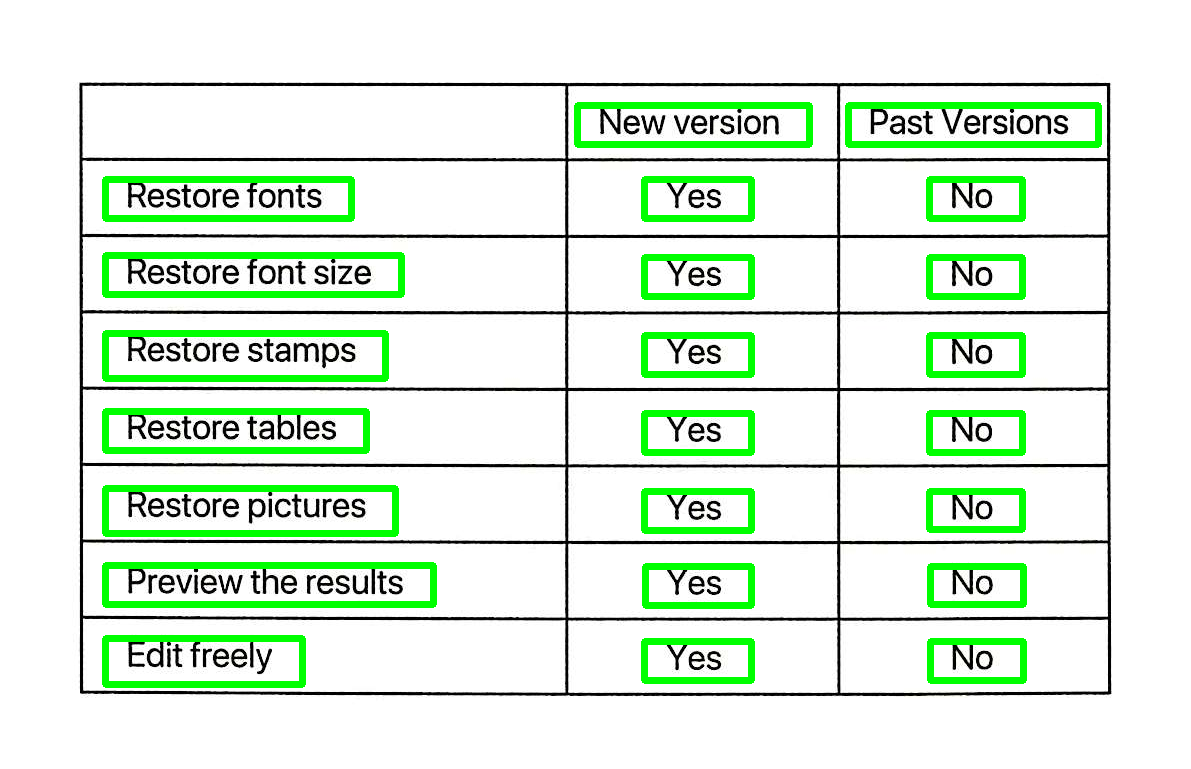

In [80]:
bounding_boxes,img_bouding_boxes = convert_contours_to_bounding_boxes(contours,image_with_padding)
Image.fromarray(img_bouding_boxes)
# img.save("img_bouding_boxes.png")

In [81]:
mean_height = get_mean_height_of_bounding_boxes(bounding_boxes)
sorted_rows = sort_and_club_all_bounding_boxes_by_similar_y_coordinates_into_rows(bounding_boxes,mean_height)
table = crop_each_bounding_box_and_ocr(sorted_rows,image_with_padding)
generate_csv_file(table)

In [82]:
table

[['New version', 'Past Versions'],
 ['Restore fonts', 'Yes', 'No'],
 ['Restore font size', 'Yes', 'No'],
 ['Restore stamps', 'Yes', 'No'],
 ['Restore tables', 'Yes', 'No'],
 ['Restore pictures', 'Yes', 'No'],
 ['Preview the results', 'Yes', 'No'],
 ['Edit freely', 'Yes', 'No']]

# Result

In [83]:
final_data = pd.read_csv("final_result.csv")
final_data

,New version,Past Versions
Restore fonts,Yes,No
Restore font size,Yes,No
Restore stamps,Yes,No
Restore tables,Yes,No
Restore pictures,Yes,No
Preview the results,Yes,No
Edit freely,Yes,No


# **Main Programme**

In [ ]:
                                                # Table Detection and Extraction From Image Project
"""
# Step 1 : Detecting the table from the image
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
from ultralyticsplus import YOLO
from PIL import Image #pillow
import cv2
import subprocess
import csv


#load The image
image = 'test3.jpg'
img = Image.open(image)

# load model
model = YOLO('keremberke/yolov8m-table-extraction')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

# perform inference
results = model.predict(img)

img = np.array(Image.open(image))
tables_vesul=[]
tables=[]

for i in range(len(results[0].boxes.data.numpy())):
  x1, y1, x2, y2, _, _ = tuple(int(item) for item in results[0].boxes.data.numpy()[i]) # (96, 586, 947, 1286)
  x2+=10
  y2+=10
  x1-=10
  y1-=10

  #cropping
  cropped_image = img[y1:y2, x1:x2]
  print(cropped_image.shape)
  tables.append(cropped_image)
  image_tab = Image.fromarray(cropped_image)
  tables_vesul.append(image_tab)

# Step 2 : Extracting data from the table

def add_10_percent_padding(img):
    image_height = img.shape[0]
    padding = int(image_height * 0.1)
    padded_img = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    return padded_img

def img_Preprocessing(img):
  # Grey-scaling
  grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # converting it to binary image by Thresholding
  thresholded_image = cv2.threshold(grayscale_image, 127, 255, cv2.THRESH_BINARY)[1]
  # Inverting
  inverted_image = cv2.bitwise_not(thresholded_image)
  return inverted_image

def img_Preprocessing_ocr(img):
  # Thresholding
  thresholded_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
  # Inverting
  # inverted_image = cv2.bitwise_not(thresholded_image)
  return thresholded_image

# Combining Vertical And Horizontal Lines
def combine_eroded_images(img):
  # Eroding Vertical Lines
  hor = np.array([[1,1,1,1,1,1]])
  ver_erode_img = cv2.erode(img, hor, iterations=5)
  ver_dilate_img = cv2.dilate(ver_erode_img, hor, iterations=10)
  # Eroding Horizontal Lines
  ver = np.array([[1],[1],[1],[1],[1],[1],[1]])
  hor_erode_img = cv2.erode(img, ver, iterations=5)
  hor_dilate_img = cv2.dilate(hor_erode_img, ver, iterations=10)
  # Combining
  combined_image = cv2.add(ver_dilate_img, hor_dilate_img)
  # dilate combined_image to make lines thicker
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
  combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=5)
  return combined_image_dilated

# Removing The Lines
def subtract_combined_and_dilated_image_from_original_image(processed_img,combined_image_dilated):
    img_without_lines = cv2.subtract(processed_img,combined_image_dilated)
    # remove noise with erode and dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    image_without_lines_noise_removed = cv2.erode(img_without_lines, kernel)
    image_without_lines_noise_removed = cv2.dilate(image_without_lines_noise_removed, kernel)
    return image_without_lines_noise_removed

# Finding The Blobs and Extracting The Text From Them

# Use Dilation To Convert The Words Into Blobs
def dilate_image(thresholded_image):
  kernel_to_remove_gaps_between_words = np.array([[1,1,1,1,1,1,1,1,1,1],[1,1,1,1,1,1,1,1,1,1]])
  dilated_image = cv2.dilate(thresholded_image, kernel_to_remove_gaps_between_words, iterations=5)
  simple_kernel = np.ones((5,5), np.uint8)
  dilated_image = cv2.dilate(dilated_image, simple_kernel, iterations=2)
  return dilated_image

# Find The Contours Of The Blobs
def find_contours(dilated_image,original_image):
    result = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = result[0]
    # The code below is for visualization purposes only.
    image_with_contours_drawn = original_image.copy()
    cv2.drawContours(image_with_contours_drawn,contours, -1, (0, 255, 0), 3)
    return contours,image_with_contours_drawn

# Convert The Blobs Into Bounding Boxes
def convert_contours_to_bounding_boxes(contours,original_image):
    bounding_boxes = []
    image_bounding_boxes = original_image.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, h))
        # The code below is for visualization purposes only.
        image_bounding_boxes = cv2.rectangle(image_bounding_boxes, (x, y), (x + w, y + h), (0, 255, 0), 5)
    return bounding_boxes,image_bounding_boxes

# Sorting The Bounding Boxes By X And Y Coordinates To Make Rows And Columns
def get_mean_height_of_bounding_boxes(bounding_boxes):
    heights = []
    for bounding_box in bounding_boxes:
        x, y, w, h = bounding_box
        heights.append(h)
    return np.mean(heights)

def sort_and_club_all_bounding_boxes_by_similar_y_coordinates_into_rows(bounding_boxes,mean_height):
    # sort_bounding_boxes_by_y_coordinate
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])
    # club_all_bounding_boxes_by_similar_y_coordinates_into_rows
    rows = []
    half_of_mean_height = mean_height / 2
    current_row = [bounding_boxes[0]]
    for bounding_box in bounding_boxes[1:]:
        current_bounding_box_y = bounding_box[1]
        previous_bounding_box_y = current_row[-1][1]
        distance_between_bounding_boxes = abs(current_bounding_box_y - previous_bounding_box_y)
        if distance_between_bounding_boxes <= half_of_mean_height:
            current_row.append(bounding_box)
        else:
            rows.append(current_row)
            current_row = [ bounding_box ]
    rows.append(current_row)

    # sort_all_rows_by_x_coordinate
    for row in rows:
        row.sort(key=lambda x: x[0])
    # Sort rows by the Y coordinate of the first box in each row
    # rows.sort(key=lambda row: row[0][1])
    return rows

# Extracting The Text From The Bounding Boxes Using OCR
def crop_each_bounding_box_and_ocr(rows,original_image):
    table = []
    current_row = []
    image_number = 0
    for row in rows:
        for bounding_box in row:
            x, y, w, h = bounding_box
            # y-=4
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
            image_without_lines_noise_removed = cv2.erode(add_10_percent_padding(original_image[y:y+h, x:x+w]), kernel)
            cropped_image = cv2.dilate(image_without_lines_noise_removed, kernel)
            image_slice_path = "img_" + str(image_number) + ".jpg"
            cv2.imwrite(image_slice_path, cropped_image)
            results_from_ocr = tesseract_results(image_slice_path)
            current_row.append(results_from_ocr)
            image_number += 1
        table.append(current_row)
        current_row = []
    return table

def tesseract_results(image_path):
    # Construct the Tesseract OCR command
    tesseract_command = (
        'tesseract ' + image_path + ' - -l fra+eng --oem 3 --psm 6 --dpi 300 '
    )
    # tesseract_command = ' tesseract  - -l fra+eng  --oem 3 --psm 6 --dpi 300 '

    # Run the Tesseract command using subprocess
    output = subprocess.getoutput(tesseract_command)
    # output = pytesseract.image_to_string(image_path)

    # Strip any leading or trailing whitespace from the output
    output = output.strip('|')
    output = output.replace('\n', ' ')
    output = output.strip()
    return output

# Generating The CSV
def generate_csv_file(input_table,i):
    with open("Extracted_table"+i+".csv", 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in input_table:
            csv_writer.writerow(row)

for i,table in enumerate(tables):
    image_with_padding = add_10_percent_padding(table)
    processed_img = img_Preprocessing(image_with_padding)
    combined_img = combine_eroded_images(processed_img)
    img_without_lines = subtract_combined_and_dilated_image_from_original_image(processed_img,combined_img)
    # Finding the cells & extracting the text using OCR
    dilated_img = dilate_image(img_without_lines)
    contours,image_with_contours_drawn = find_contours(dilated_img,image_with_padding)
    bounding_boxes,img_bouding_boxes = convert_contours_to_bounding_boxes(contours,image_with_padding)
    mean_height = get_mean_height_of_bounding_boxes(bounding_boxes)
    sorted_rows = sort_and_club_all_bounding_boxes_by_similar_y_coordinates_into_rows(bounding_boxes,mean_height)
    table = crop_each_bounding_box_and_ocr(sorted_rows,image_with_padding)
    generate_csv_file(table,i)
"""

In [ ]:
'''
final_data_test3 = pd.read_csv("Extracted_table.csv")
final_data_test3
'''

# Solution 2 to detect the Table in the image return coords

In [86]:
# !pip install img2table

In [ ]:
"""
from img2table.document import Image

# Instantiation of the image
img = Image(src="test4.jpg")

# Table identification
imgage_tables = img.extract_tables()

# Result of table identification
imgage_tables
"""